# AGH Modelling of Physical Systems Lab 3 (2025 March 18th)
Sylwester Arabas (sylwester.arabas@agh.edu.pl)

### Solution: Jakub Kot

**1. advection PDE**

Let's introduce a few symbols:   
* ${\color{red}t}$: time   
* ${\color{blue}x}$: physical coordinate (e.g., distance or altitude)   
* ${\color{green}\psi}({\color{blue}x})$: scalar field (e.g., pollutant concentration)   
* ${\color{brown}u}$: carrier velocity field (e.g., wind)   

Transport of $\color{green}\psi$ due to advection by $\color{brown}u$ can be modelled with the advection equation:
$$ \partial_{\color{red} t} {\color{green}\psi} + \partial_{\color{blue}x} \left({\color{brown}u} {\color{green}\psi}\right) = 0 $$

For the special case of $\partial_{\color{blue}x} {\color{brown}u}=0$, an analytical solution describing translation of the signal is readily available:
$$ {\color{green}\psi}({\color{blue}x}, {\color{red}t})=\psi_0({\color{blue}x} - {\color{brown}u}{\color{red}t})$$
where $\psi_0({\color{blue}x})={\color{green}\psi}({\color{blue}x}, 0)$. 

Let's depict the problem using NumPy and matplotlib:

In [1]:
import numpy as np
from matplotlib import pyplot
from open_atmos_jupyter_utils import show_plot

In [2]:
class Psi_0:
    def __init__(self):
        self.x0 = 5
        self.a = 1
        self.sigma = 25
    def __call__(self, x):
        return self.a * np.exp(-(x-self.x0)**2 / 2 / self.sigma**2)

In [3]:
psi_0 = Psi_0()
nx = 64
x, dx = np.linspace(-100, 300, nx, endpoint=False, retstep=True)
u = 2
t_max = 50

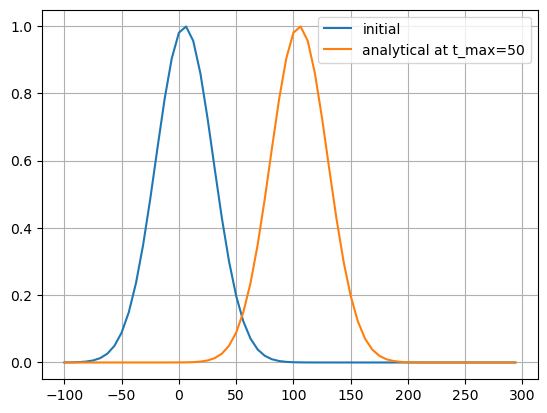

In [4]:
pyplot.plot(x, psi_0(x), label='initial')
pyplot.plot(x, psi_0(x - u * t_max), label=f'analytical at {t_max=}')
pyplot.legend()
pyplot.grid()

**2. overview of applications**

* **computational fluid dynamics**: Navier-Stokes momentum equation ($\psi$: fluid momentum)
* **fluid thermodynamics**: energy conservation ($\psi$: thermal energy)
* **atmospheric modelling incl. weather prediction**: mass conservation ($\psi$: humidity, rain, pollutants, ...)
* **derivative pricing in financial mathematics**: Black-Scholes equation ($\psi$: discounted value of a derivative instrument)
* ...

**3. simple numerical solution using the "upwind" scheme coded in Python**

For cases where the velocity varies in space (and for many other more complex cases), numerical integration is the only way of solving the advection PDE. Among numerous numerical schemes for solving it, let's look at the basic [**upwind**](https://en.wikipedia.org/wiki/Upwind_scheme) solver: 

Let's consider the following discretisation of the problem:   
* ${\color{red}n} = \frac{\color{red}t}{\Delta t} \in 0, 1, \ldots$   
* ${\color{blue}i} = \frac{\color{blue}x}{\Delta x} \in 0, 1, \ldots$   
* ${\color{brown}C} = {\color{brown}u}\frac{\Delta t}{\Delta x}$ (so called Courant number)   
* ${\color{green}\psi}_{\color{blue}i}^{\color{red}n}$: scalar field at "grid cell" $\color{blue}i$ in space at time "level" ${\color{red}n}$   

The explicit (forward-in-time) upwind scheme is defined as:
$$
  {\color{green}\psi}^{{\color{red}n}+1}_{\color{blue}i} = {\color{green}\psi}^{\color{red}n}_{\color{blue}i} - \left[F\left({\color{green}\psi}^{\color{red}n}_{\color{blue}i},  {\color{green}\psi}^{\color{red}n}_{{\color{blue}i}+1}, {\color{brown}C}\right)-F\left({\color{green}\psi}^{\color{red}n}_{{\color{blue}i}-1},{\color{green}\psi}^{\color{red}n}_{\color{blue}i}, {\color{brown}C}\right)\right]
$$
$$F(\psi_L, \psi_R, C)=\frac{C+|C|}{2}\psi_L + \frac{C-|C|}{2}\psi_R$$

**4. upwind algorithm coded in Python/NumPy: functions and a useful structure**

In [5]:
class One:
    def __radd__(self, other):
        return slice(other.start+1, other.stop+1, 1)
    
    def __rsub__(self, other):
        return slice(other.start-1, other.stop-1, 1)


def F(L, R, C):
    return .5 * (C + abs(C)) * L + \
           .5 * (C - abs(C)) * R


**5. upwind algorithm coded in Python/NumPy: data/objects**

In [6]:
nt = 16
one = One()
dt = t_max / nt
C = u * dt / dx
i = slice(1, nx-2)

psi = psi_0(x)

**6. upwind algorithm coded in Python/NumPy: time-stepping loop**

In [7]:
for _ in range(nt):
    psi[i] = psi[i] - (F(psi[i], psi[i+one], C) - F(psi[i-one], psi[i], C))

**7. comparing analytic and numerical solutions**

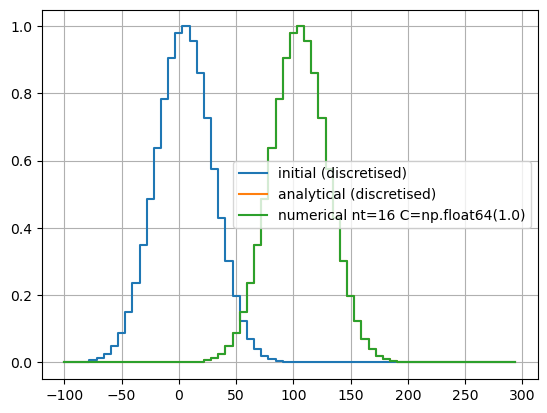

In [8]:
pyplot.step(x, psi_0(x), label='initial (discretised)', where='mid')
pyplot.step(x, psi_0(x-u*t_max), label='analytical (discretised)', where='mid')
pyplot.step(x, psi, label=f'numerical {nt=} {C=}', where='mid')
pyplot.legend()
pyplot.grid()

## Goal of the analysis
The goal of the analysis is to compare the analytical solution of the advection with the numerical solution obtained using the upwind scheme, to assess the accuracy of the numerical method.

The comparison will be done for different values of the Courant number.

## Approach

For a given Courant number, the following steps will be performed:

- Set the initial conditions for the advection problem.

- Set the parameters for the numerical method.

- Compute the analytical solution.

- Compute the numerical solution.

- Compare the analytical and numerical solutions by calculating the error.

The process will be repeated for different values of the Courant number to observe how the numerical solution behaves as the Courant number changes.

The results will be visualized using matplotlib to show the error between the analytical and numerical solutions.

## RMSE
Commonly used error measure is the root mean square error (RMSE). It's calculated as a quadratic mean of the difference between the numerical and analytical solutions.

In [9]:
def calc_rmse(x1, x2):
    return np.sqrt(np.mean((x1-x2)**2))

In [10]:
def advection(grid, u, courant_const, dx):
    dt_val = courant_const * dx / u
    total_steps = int(t_max / dt_val)
    num_points = grid.shape[0]
    
    local_C = u * dt_val / dx
    
    psi = psi_0(grid)
    update_indices = np.arange(1, num_points - 2)
    
    for _ in range(total_steps):
        psi[update_indices] -= (F(psi[update_indices], psi[update_indices + 1], local_C) - 
                                      F(psi[update_indices - 1], psi[update_indices], local_C))
    return psi

In [11]:
def calc_errors(x, u, courant_const, dx):
    rmse_vals = np.array([])
    x_start, x_end = x[0], x[-1]
    for dx_val in dx:
        n_points = int((x_end - x_start) / dx_val)
        grid = np.linspace(x_start, x_end, n_points, endpoint=False)
        numerical = advection(grid, u, courant_const, dx_val)
        analytic = psi_0(grid - u * t_max)
        # rmse_vals.append(calc_rmse(numerical, analytic))
        rmse_vals = np.append(rmse_vals, calc_rmse(numerical, analytic))
    return rmse_vals

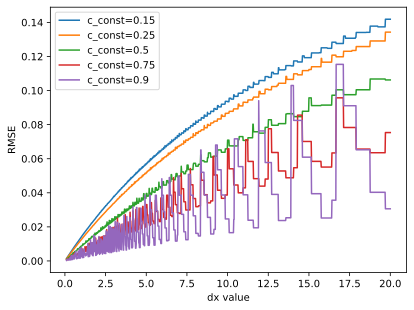

In [ ]:
dx_linspace = np.linspace(0.1, 20, 1000)
u = 1.5

c_values = [0.15, 0.25, 0.5, 0.75, 0.9]

for c_val in c_values:
    errors = calc_errors(x, u, c_val, dx_linspace)
    pyplot.plot(dx_linspace, errors, label=f'c_const={c_val}')
    pyplot.xlabel('dx value')
    pyplot.ylabel('RMSE')
    pyplot.legend()
show_plot(filename='advection_errors.png')

## Conclusion
We can observe from the plot that the RMSE increases with the increasing dx values. This is expected, as larger dx values lead to a lower resolution grid and less accurate numerical solution.

The RMSE grows higher for smaller Courant numbers, however higher Courant numbers lead to higher numerical instability.